In [1]:
import sys
import os

# Get the absolute path to the project directory
project_dir = os.path.abspath("..")

# Append the project directory to sys.path
if project_dir not in sys.path:
    sys.path.append(project_dir)

import yfinance as yf
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import warnings
from dataclasses import asdict, is_dataclass, dataclass
import os
import json
import pickle
from pandas.api.types import is_datetime64_any_dtype
import scipy
import numpy as np
from scipy.stats import linregress
import bisect
from scipy import stats

from src.common.AssetData import AssetData
from src.common.AssetDataService import AssetDataService
from src.common.AssetFileInOut import AssetFileInOut 
from src.databaseService.OutsourceLoader import OutsourceLoader

from src.simulation.SimulatePortfolio import SimulatePortfolio
from src.strategy.StratBuyAndHold import StratBuyAndHold
from src.simulation.ResultAnalyzer import ResultAnalyzer
from src.common.AssetFileInOut import AssetFileInOut
from src.mathTools.CurveAnalysis import CurveAnalysis
from src.predictionModule.FourierML import FourierML
from src.common.YamlTickerInOut import YamlTickerInOut
from src.common.DataFrameTimeOperations import DataFrameTimeOperationsPandas as DFTO
from src.mathTools.SpecialMatrix import SpecialMatrix
from src.mathTools.DistributionTools import DistributionTools


In [12]:
num_sam_tr = 60  # matrix size
n_diags = 4      # number of off-diagonals on each side
A_sparse = SpecialMatrix.boundedDiagonal_oneNetCol(num_sam_tr, n_diags)

# For demonstration: print the sparse matrix in dense form.
A_full = A_sparse.todense()

# --- 3. Print the matrices ---
print("\nFull dense matrix A_full:\n", A_full[0])
#print("\nSparse matrix A_sparse:")
#print(A_sparse)

# --- 4. Matrix-vector multiplication ---
x = np.random.rand(num_sam_tr)
y_full = A_full @ x
y_sparse = A_sparse @ x

print("All are close:", np.allclose(y_full, y_sparse))  # True


Full dense matrix A_full:
 [[0.2        0.16666667 0.14285714 0.125      0.11111111 0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]]
All are close: True


In [ ]:
import scipy.sparse.linalg as spla


num_sam_tr = 8  # matrix size
n_diags = 3      # number of off-diagonals on each side
A_sparse = SpecialMatrix.boundedDiagonal_sparse(num_sam_tr, n_diags)

# For demonstration: print the sparse matrix in dense form.
A_full = A_sparse.todense()

## --- 5. Inverse matrix-vector multiplication ---
x = np.random.rand(num_sam_tr)
## Solve A*y = x for y.
y_inv_full = np.linalg.solve(A_full, x)
y_inv_sparse = spla.spsolve(A_sparse, x)
print("\nInverse matrix-vector multiplication (solving A*y = x):")
print("Absolute difference:\n", np.mean(np.abs(y_inv_full - y_inv_sparse)))

# --- Compute numerical rank and determinant for the dense matrix A_full ---
U, s, Vh = np.linalg.svd(A_full)
tol = max(A_full.shape) * np.amax(s) * np.finfo(s.dtype).eps
num_rank_full = np.sum(s > tol)
det_full = np.linalg.det(A_full)
print("Dense matrix:")
print("  Numerical rank:", num_rank_full)
print("  Determinant:", det_full)


Inverse matrix-vector multiplication (solving A*y = x):
Absolute difference:
 2600040400926568.0
Dense matrix:
  Numerical rank: 7
  Determinant: 2.0706540538643876e-17


matrix([[ 0.45067453],
        [-0.14372927],
        [-0.20424094],
        [-0.54761511],
        [ 0.49338753],
        [ 0.45388748],
        [-0.31895834],
        [-0.18340588]])

In [ ]:
import numpy as np

def circulant_multiply(c, x):
    """Multiply circulant matrix (defined by first column c) by vector x."""
    return np.real(np.fft.ifft(np.fft.fft(c) * np.fft.fft(x)))

def circulant_inverse_multiply(c, b):
    """Solve Ax = b for circulant matrix A defined by first column c."""
    eigenvalues = np.fft.fft(c)
    print(f"Lowest eigenvalue: {np.min(np.abs(eigenvalues))}")
    if np.any(np.abs(eigenvalues) < 1e-12):
        raise ValueError("Circulant matrix is singular!")
    return np.real(np.fft.ifft(np.fft.fft(b) / eigenvalues))

def circulant_coeffs(n, a):
    # Compute cyclic distances: d[k] = min(k, n-k)
    d = np.minimum(np.arange(n), n - np.arange(n))
    # Exponential decay: main diagonal is 1, neighbors decay as exp(-a*d)
    coeffs = np.exp(-a * d)
    # Normalize so the coefficients sum to 1
    return coeffs / coeffs.sum()
# Example usage:
num_sam_tr = 20
c = circulant_coeffs(num_sam_tr, 0.5)  # first column of the circulant matrix
eps = 1e-6 # to avoid singular matrix
c[0] -= 1 - eps
x = np.random.rand(num_sam_tr)  # vector to multiply

# Multiply circulant matrix by x
y = circulant_multiply(c, x)
print("Result of circulant multiply:", y)

# Now, solve Ax = y to recover x
x_recovered = circulant_inverse_multiply(c, y)
print("Original x:", x)
print("Recovered x:", x_recovered)

Result of circulant multiply: [ 0.21012606 -0.13314346  0.15737162  0.02087521 -0.03788862 -0.15362854
  0.15314803 -0.16258518  0.37174242 -0.10257611 -0.03736177 -0.26782281
 -0.06814705  0.04932619  0.29093784 -0.02471498 -0.33416127  0.04366359
  0.22688358 -0.20203418]
Lowest eigenvalue: 9.999999999177334e-07
Original x: [0.24748827 0.60572137 0.29671893 0.45556372 0.54210204 0.67540687
 0.34681953 0.68082847 0.12293884 0.66881797 0.64903305 0.91469166
 0.68131546 0.51208106 0.23120074 0.58238626 0.92121761 0.4864869
 0.25784285 0.69901605]
Recovered x: [0.24748827 0.60572137 0.29671893 0.45556372 0.54210204 0.67540687
 0.34681953 0.68082847 0.12293884 0.66881797 0.64903305 0.91469166
 0.68131546 0.51208106 0.23120074 0.58238626 0.92121761 0.4864869
 0.25784285 0.69901605]


In [7]:
num_sam_tr = 50000
num_sam_te = 1000
diagonal_num = 0
n_feat = 10
sam_tr = np.zeros((num_sam_tr, n_feat), dtype=float)
sam_te = np.zeros((num_sam_te, n_feat), dtype=float)

for i in range(n_feat):
    sam_tr[:,i] = np.random.normal(loc=0-i/5000, scale=2+i/3000, size=num_sam_tr) #train
    sam_te[:,i] = np.random.normal(loc=0+i/5000, scale=1-i/3000, size=num_sam_te) #test
sam_te[:,-3] = np.random.normal(loc=0+0.3, scale=1, size=num_sam_te) + np.random.normal(loc=-0.3, scale=1.2, size=num_sam_te)
sam_te[:,-2] = np.random.uniform(low=-0.5, high=0.5, size=num_sam_te)
sam_te[:,-1] = np.random.uniform(low=-1.9, high=1.9, size=num_sam_te)

argsort_sam_tr = np.argsort(sam_tr, axis=0)
argsort_sam_te = np.argsort(sam_te, axis=0)
re_argsort_sam_tr = np.argsort(argsort_sam_tr, axis=0)
re_argsort_sam_te = np.argsort(argsort_sam_te, axis=0)
sort_sam_tr = np.sort(sam_tr, axis=0)
sort_sam_te = np.sort(sam_te, axis=0)

ksDist = DistributionTools.ksDistance(sam_tr, sam_te, weights=None)
print(ksDist.mean())

importance = np.zeros(n_feat)
importance[0] = 1
s = DistributionTools.establishMatchingWeight_test(sam_tr, sam_te, 10, 0.4)
#s = weights @ importance

ksDist_s = DistributionTools.ksDistance(sam_tr, sam_te, weights=s)
print(ksDist_s.mean())

fig, axs = plt.subplots(n_feat, 1, figsize=(6, 4 * n_feat))
for cube_idx in range(n_feat):
    # sort s according to the training samples for this cube_idx
    s_sorted = s[argsort_sam_tr[:, cube_idx]]
    s_cum = np.cumsum(s_sorted) / np.sum(s_sorted)
    
    axs[cube_idx].scatter(sort_sam_tr[:, cube_idx], s_cum,
                           label='S Distribution', marker='.', edgecolors='blue')
    axs[cube_idx].scatter(sort_sam_te[:, cube_idx],
                           np.linspace(0, 1, num_sam_te),
                           label='Test Distribution', marker='.', edgecolors='red')
    axs[cube_idx].set_title(f'Sample Distribution (cube_idx = {cube_idx})')
    axs[cube_idx].set_xlabel('x')
    axs[cube_idx].set_ylabel('Density')
    axs[cube_idx].legend()

plt.legend()
plt.tight_layout()
plt.show()
    

0.8001271413189974
0.30741876695259523


In [5]:
ksDist_s

array([0.32109053, 0.34814003, 0.325643  , 0.09236356, 0.70709246,
       0.3234183 ])

In [20]:
import bisect

def count_entries_between(v, w):
    lo = np.searchsorted(w, v[:-1], side="right")
    hi = np.searchsorted(w, v[1:], side="left")
    return hi - lo

# Example usage:
v = [1, 3, 5, 10]
w = [2, 4, 6, 7, 9]
print(count_entries_between(v, w))

w=np.array(w).astype(int)


[1 1 3]


In [51]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)
num_sam_tr = 1000
# Generate samples from a normal distribution
data = np.random.normal(loc=0, scale=1, size=num_sam_tr)

# Create random weights and normalize them to sum to 1
weights = np.random.rand(num_sam_tr)+0.5
weights /= weights.sum()

# Sort data and associated weights
sorted_indices = np.argsort(data)
data_sorted = data[sorted_indices]
weights_sorted = weights[sorted_indices]

# Compute the weighted cumulative sum (CDF)
cdf = np.cumsum(weights_sorted)

# Plot the weighted CDF
plt.step(data_sorted, cdf, where='post')
plt.xlabel('Data')
plt.ylabel('Weighted CDF')
plt.title('Weighted CDF for Normal Distribution')
plt.show()

In [71]:
num_sam2 = 100000
num_sam1 = 100000//10
sam1 = np.random.normal(loc=0, scale=1, size=num_sam1) #test
sam2 = np.random.normal(loc=0, scale=2, size=num_sam2) #train

argsort_sam1 = np.argsort(sam1)
argsort_sam2 = np.argsort(sam2)
sort_sam1 = sam1[argsort_sam1]
sort_sam2 = sam2[argsort_sam2]

#diff_sort_sam1 = np.diff(sort_sam1)
#diff_sort_sam2 = np.diff(sort_sam2)
#diff_xpts = np.diff(xpts)
#
#quot_sam1 = diff_xpts / diff_sort_sam1
#quot_sam2 = diff_xpts / diff_sort_sam2
#
#quot = quot_sam1 / quot_sam2

def count_entries_between(v, w):
    lo = np.searchsorted(w, v[:-1], side="right")
    hi = np.searchsorted(w, v[1:], side="left")
    return hi - lo
def smooth_array(data, window_size=3):
    # Create a uniform window
    window = np.ones(window_size) / window_size
    # Convolve while keeping the output length the same
    return np.convolve(data, window, mode='same')

weights2 = count_entries_between(sort_sam2, sort_sam1)
weights2 = smooth_array(weights2, window_size = 10)
#weights2 = np.ones(num_sam2)
weights2 = np.insert(weights2, 0, weights2[0])
weights2 *= num_sam2/np.sum(weights2)

weights0 = np.ones(num_sam2)
cdf2 = np.cumsum(weights2)
cdf2 = cdf2 / cdf2[-1]
weights2_org = weights2[np.argsort(argsort_sam1)]
plt.plot(weights2)
plt.show()

print(np.cumsum(weights2)[-1])
print(np.cumsum(weights0)[-1])
print(np.sum(weights0))
# Plot the weighted CDF
plt.step(sort_sam2, cdf2, where='post', color='green')
plt.xlabel('Data')
plt.ylabel('Weighted CDF')
plt.title('Weighted Cumulative Distribution Function')

#isam1 = np.searchsorted(sort_sam1, xpts)

plt.scatter(sort_sam1, np.linspace(0, 1, num_sam1), label='Sam test', marker='.', linestyle='--', linewidths=0.1, edgecolors='blue')
plt.scatter(sort_sam2, np.linspace(0, 1, num_sam2), label='Sam train', marker='.', linestyle='--', linewidths=0.1, edgecolors='red')
plt.title('samples')
plt.xlabel('x')
plt.ylabel('Density')
plt.legend()
plt.show()

100000.0
100000.0
100000.0


In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Define the sampling function
def f():
    return np.random.normal(loc=0, scale=1)

# Generate samples
num_samples = 1000000
samples = [f() for _ in range(num_samples)]
subsample = np.array([f() for _ in range(1000)])

# Estimate PDF using scipy's gaussian_kde
kde = gaussian_kde(samples)

interp_num = 50
interp_pts_train = np.linspace(np.min(samples), np.max(samples), interp_num)
kde_train_values = gaussian_kde(samples)(interp_pts_train)
interp_values_train = np.interp(subsample, interp_pts_train, kde_train_values)

# Plot the estimated PDF and the true PDF
plt.scatter(subsample, interp_values_train, label='Estimated PDF (KDE)', marker='o', linestyle='--')
plt.scatter(subsample, (1/np.sqrt(2*np.pi)) * np.exp(-0.5 * subsample**2), 
         label='True PDF', marker='o', linestyle='--')
plt.title('PDF Estimation')
plt.xlabel('x')
plt.ylabel('Density')
plt.legend()
plt.show()

# Evaluate the PDF at a specific point
x = 1.0
pdf_at_x = kde(x)
print(f"Estimated PDF at x = {x}: {pdf_at_x}")



Estimated PDF at x = 1.0: [0.24313536]


In [20]:
import lightgbm as lgb
import shap
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Load dataset
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()
df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = data.target

X = df.drop('target', axis=1)
y = df['target']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train LightGBM
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'verbosity': -1,
    'num_boost_round': 1000,
    'boosting_type': 'gbdt',
    'seed': 42
}

gbm = lgb.train(params,
                train_data)
print( "Best iteration: ", gbm.best_iteration)

y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)
y_pred_binary = (y_pred >= 0.5).astype(int)
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy with ALL features: {accuracy:.4f}")
warnings.filterwarnings("ignore", message="LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray")
# Explain with SHAP
explainer = shap.TreeExplainer(gbm)
shap_values = explainer.shap_values(X_test)

# Feature importance
print(shap_values.shape)
mean_abs_shap = np.abs(shap_values).mean(axis=0)
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'mean_abs_shap': mean_abs_shap
}).sort_values(by='mean_abs_shap', ascending=False)

# Select top 10 features
print("Number of features: ", len(feature_importance))
print("Feature importance: ", feature_importance)
top_n = 10
top_features = feature_importance.head(top_n)['feature'].tolist()

# Filter data
X_train_filtered = X_train[top_features]
X_test_filtered = X_test[top_features]

# Retrain model
train_data_filtered = lgb.Dataset(X_train_filtered, label=y_train)
test_data_filtered = lgb.Dataset(X_test_filtered, label=y_test, reference=train_data_filtered)

gbm_filtered = lgb.train(params,
                         train_data_filtered)

# Predict and evaluate
y_pred = gbm_filtered.predict(X_test_filtered, num_iteration=gbm_filtered.best_iteration)
y_pred_binary = (y_pred >= 0.5).astype(int)
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy with top {top_n} features: {accuracy:.4f}")


c:\Users\kimer\Desktop\RandomOdyssey\.venv\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Best iteration:  0
Accuracy with ALL features: 0.9737
(114, 30)
Number of features:  30
Feature importance:                      feature  mean_abs_shap
27     worst concave points       2.611242
26          worst concavity       2.143525
7       mean concave points       1.864656
23               worst area       1.837768
22          worst perimeter       1.796640
21            worst texture       1.307580
1              mean texture       1.273500
13               area error       1.201572
28           worst symmetry       1.099332
15        compactness error       0.989048
3                 mean area       0.641268
24         worst smoothness       0.596307
20             worst radius       0.579570
18           symmetry error       0.538147
4           mean smoothness       0.522940
6            mean concavity       0.415951
10             radius error       0.337194
5          mean compactness       0.333418
17     concave points error       0.281908
8             mean symmetry    

c:\Users\kimer\Desktop\RandomOdyssey\.venv\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Accuracy with top 10 features: 0.9737


In [119]:
import numpy as np

# Mock feature_importances vector
feature_importances = np.array([0.1, 0.3, 0.2, 0.4, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

# Parameters
p_features = 0.1  # Select top 40% features

# Original code logic
argsort_features = np.argsort(feature_importances)
print(argsort_features)
pN = int(np.ceil(p_features * len(feature_importances)))
print(pN)
top_indices = argsort_features[-pN:]
mask = np.zeros_like(feature_importances, dtype=bool)
mask[top_indices] = True
print(mask)

[ 7  6  5  4 11 10  9  8 12 13 14  0  2  1  3]
2
[False  True False  True False False False False False False False False
 False False False]


In [67]:
# Import necessary libraries
import numpy as np
import pandas as pd

# Define the class with the __mask_unweightedFeatures method
class FeatureMasker:
    def __init__(self, X_train, featureColumnNames):
        self.X_train = X_train
        self.featureColumnNames = featureColumnNames
    
    def mask_unweightedFeatures(self):
        feature_names = np.array(self.featureColumnNames).astype(str)
        patterns = [
            'Seasonal', 
            'Category', 
            'daysToReport', 
            '_rank', '_Rank', '_RANK',
            ]
        mask = np.ones(self.X_train.shape[1], dtype=bool)
        for pattern in patterns:
            mask &= ~(np.char.find(feature_names, pattern) >= 0)
        return mask

# Create sample data
X_train = np.random.rand(100, 10)  # 100 samples, 10 features
featureColumnNames = [
    'feature1', 'Seasonal_Temp', 'category_type', 'feature4_rank',
    'daysToReport', 'feature6', 'feature7', 'feature8', 'feature9', 'feature10'
]

# Instantiate the FeatureMasker
masker = FeatureMasker(X_train, featureColumnNames)

# Apply the masking method
mask = masker.mask_unweightedFeatures()

# Display the results
print("Feature Column Names:")
print(featureColumnNames)
print("\nMask (True = Keep, False = Mask):")
print(mask)


Feature Column Names:
['feature1', 'Seasonal_Temp', 'category_type', 'feature4_rank', 'daysToReport', 'feature6', 'feature7', 'feature8', 'feature9', 'feature10']

Mask (True = Keep, False = Mask):
[ True False  True False False  True  True  True  True  True]


1000
801
100


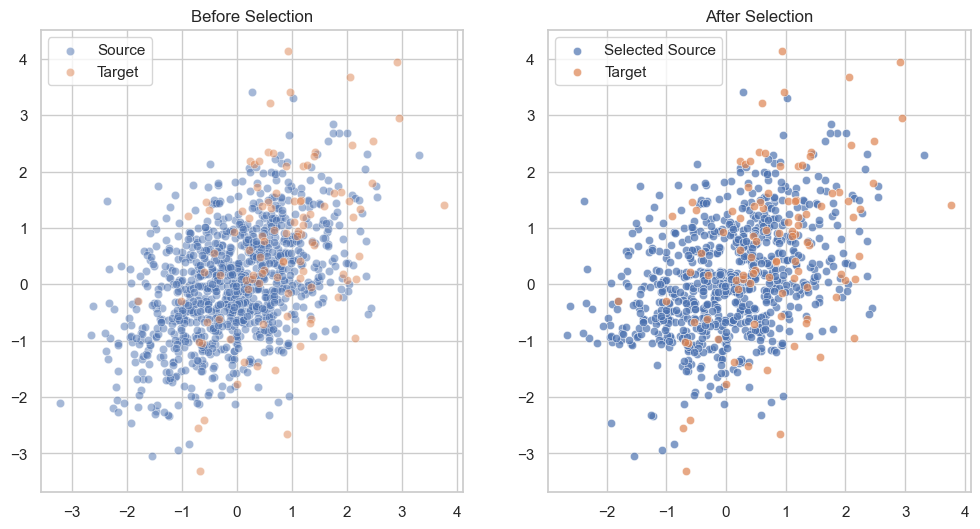

In [27]:
# Select Source Subset Example
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KernelDensity
import lightgbm as lgb

def select_source_subset(source_X, target_X, fraction=0.9, random_state=None):
    source_X, target_X = map(np.asarray, (source_X, target_X))
    n_source = len(source_X)
    
    combined_X = np.vstack((source_X, target_X))
    combined_y = np.concatenate((np.zeros(n_source), np.ones(len(target_X))))
    
    lgb_params  = {
        'verbosity': -1,
        'n_jobs': -1,
        'is_unbalance': True,
        'objective': 'binary',
        'n_estimators': 16000,
        'num_leaves': 1024*4,
        'max_depth': 30,
        'learning_rate': 0.1,
        'random_state': 41,
    }
    
    model = lgb.LGBMClassifier(**lgb_params)
    model.fit(combined_X, combined_y)
    
    scores = model.predict_proba(combined_X)[:, 1]
    distances, _ = NearestNeighbors(n_neighbors=1).fit(scores[n_source:].reshape(-1,1)) \
                                                 .kneighbors(scores[:n_source].reshape(-1,1))
    distances = distances.ravel()
    cutoff = np.quantile(distances, fraction)
    
    scores = model.predict_proba(source_X)[:, 1]
    cutoff = np.quantile(scores, 1-fraction)
    return scores >= cutoff

# Generate synthetic data
sns.set(style="whitegrid")
np.random.seed(42)
source_X = np.random.multivariate_normal([0, 0], [[1, 0.5],[0.5, 1]], 1000)
target_X = np.random.multivariate_normal([0.9, 0.9], [[1, 0.5],[0.5, 2]], 100)

# Select subset
mask = select_source_subset(source_X, target_X, fraction=0.8, random_state=42)
selected_source = source_X[mask]
print(len(source_X))
print(len(selected_source))
print(len(target_X))

# Plotting
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(x=source_X[:,0], y=source_X[:,1], label='Source', alpha=0.5)
sns.scatterplot(x=target_X[:,0], y=target_X[:,1], label='Target', alpha=0.5)
plt.title('Before Selection')

plt.subplot(1, 2, 2)
sns.scatterplot(x=selected_source[:,0], y=selected_source[:,1], label='Selected Source', alpha=0.7)
sns.scatterplot(x=target_X[:,0], y=target_X[:,1], label='Target', alpha=0.7)
plt.title('After Selection')

plt.legend()
plt.show()


In [46]:
# Quantile Matching Example Notebook

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Quantile Matching Function
def quantile_matching_mask(source, target):
    source = np.asarray(source)
    target = np.asarray(target)
    M = len(target)
    N = len(source)
    
    # Sort source and target
    sorted_source = np.sort(source)
    sorted_target = np.sort(target)
    
    # Compute target quantiles
    quantiles = np.linspace(0, 1, M, endpoint=False) + 0.5/M
    
    # Find corresponding indices in source
    indices = (quantiles * N).astype(int)
    indices = np.clip(indices, 0, N-1)
    
    # Create mask
    mask = np.zeros(N, dtype=bool)
    mask[indices] = True
    return mask

# Generate Source and Target with Same Support [0,1] but Different Distributions
np.random.seed(42)
# Source has higher density where target has higher density
source = np.random.beta(a=4, b=3, size=10000)
target = np.random.beta(a=3, b=4, size=2000)

# Apply Quantile Matching
mask = quantile_matching_mask(source, target)

# Plotting
sns.set(style="whitegrid")

plt.figure(figsize=(18, 5))

# Source Distribution
plt.subplot(1, 3, 1)
sns.histplot(source, bins=30, kde=True, color='skyblue')
plt.title('Source Distribution')

# Target Distribution
plt.subplot(1, 3, 2)
sns.histplot(target, bins=30, kde=True, color='salmon')
plt.title('Target Distribution')

# Source with Mask
plt.subplot(1, 3, 3)
sns.histplot(source, bins=30, kde=True, color='skyblue', label='Source', stat="density")
sns.histplot(source[mask], bins=30, kde=True, color='salmon', label='Matched', stat="density", alpha=0.6)
plt.title('Quantile Matched Source')
plt.legend()

plt.tight_layout()
plt.show()


In [59]:
A = [-1, 1, 1e-16, 1, 1, 0, 1]
print(np.array(A) > 0)
A = np.array(A) > 0
print("A",A)
B = np.array([1,0,0,1,1], dtype=bool)
print("B",B)
A[A] = B
print("A",A)

[False  True  True  True  True False  True]
A [False  True  True  True  True False  True]
B [ True False False  True  True]
A [False  True False False  True False  True]


In [21]:
def pick_subset(A, B):
    """
    Returns a boolean array of size N with L True values, selecting the subset
    specified by B from the True entries in A.
    """
    original_mask = np.array(A, dtype=bool)
    subset_mask = np.array(B, dtype=bool)
    idx = np.where(original_mask)[0]
    out = np.zeros_like(original_mask, dtype=bool)
    out[idx[subset_mask]] = True
    return out

# Example usage:
A = [0, 1, 0, 1, 1, 0, 1]
B = [1, 0, 1, 0]  # Select subset from A's ones
print(pick_subset(A, np.array(B, dtype=bool)))
# Output: [0 1 0 0 1 0 0]
idx = np.where(A)[0]
print(idx)
out = np.zeros_like(A, dtype=bool)
print(idx[np.array(B, dtype=bool)])
out[idx[np.array(B, dtype=bool)]]=True
print(out)

[False  True False False  True False False]
[1 3 4 6]
[1 4]
[False  True False False  True False False]
[1 3 4 6]


In [8]:
# Sample Data
X_test_norm = np.random.rand(5, 3)   # 5 test samples, 3 features
X_train_norm = np.random.rand(4, 3)  # 4 train samples, 3 features

print(X_train_norm[:, None, :])
print(X_test_norm)
np.abs(X_train_norm[:, None, :] - X_test_norm)

[[[0.38640269 0.64607256 0.92112843]]

 [[0.38524554 0.56028197 0.99550772]]

 [[0.03285965 0.28969478 0.99768124]]

 [[0.06372088 0.6909881  0.69525666]]]
[[0.67853224 0.47080179 0.36310218]
 [0.35942609 0.33641013 0.56526316]
 [0.09229147 0.53264402 0.83398952]
 [0.37109065 0.37324073 0.90558679]
 [0.47918325 0.29459973 0.30268811]]


array([[[0.29212955, 0.17527077, 0.55802625],
        [0.0269766 , 0.30966243, 0.35586527],
        [0.29411122, 0.11342854, 0.08713891],
        [0.01531204, 0.27283183, 0.01554164],
        [0.09278056, 0.35147282, 0.61844032]],

       [[0.2932867 , 0.08948018, 0.63240554],
        [0.02581945, 0.22387184, 0.43024456],
        [0.29295407, 0.02763795, 0.1615182 ],
        [0.01415489, 0.18704124, 0.08992093],
        [0.0939377 , 0.26568224, 0.69281961]],

       [[0.64567259, 0.181107  , 0.63457906],
        [0.32656644, 0.04671534, 0.43241808],
        [0.05943182, 0.24294924, 0.16369172],
        [0.338231  , 0.08354594, 0.09209445],
        [0.44632359, 0.00490495, 0.69499313]],

       [[0.61481137, 0.22018631, 0.33215448],
        [0.29570521, 0.35457797, 0.12999349],
        [0.02857059, 0.15834408, 0.13873286],
        [0.30736977, 0.31774737, 0.21033013],
        [0.41546237, 0.39638836, 0.39256855]]])

In [6]:
# Sample Data
X_test_norm = np.random.rand(5, 3)   # 5 test samples, 3 features
X_train_norm = np.random.rand(4, 3)  # 4 train samples, 3 features

# Vectorized Approach
mean_val_vectorized = np.mean(np.sqrt(np.abs(X_train_norm[:, None, :] - X_test_norm)), axis=1)

# Iterative Approach
mean_val_iterative = np.empty(X_train_norm.shape)
for i in range(X_train_norm.shape[0]):
    mean_val_iterative[i, :] = np.mean(
        np.sqrt(np.abs(X_train_norm[i, :] - X_test_norm)),
        axis=0
    )

# Verify Equivalence
assert np.allclose(mean_val_vectorized, mean_val_iterative)

In [13]:
import pandas as pd
from sklearn.impute import KNNImputer

# Sample DataFrame with missing values
data = {
    'A': [1, 2, None, 4,5,None],
    'B': [None, 2, 3, None,5,6],
    'C': [1, None, 3, 4,5, None]
}
df = pd.DataFrame(data)

# Initialize KNNImputer
imputer = KNNImputer(n_neighbors=3, weights='distance')

# Perform the imputation
df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

print(df_imputed)

     A         B    C
0  1.0  2.714286  1.0
1  2.0  2.000000  2.4
2  2.6  3.000000  3.0
3  4.0  3.600000  4.0
4  5.0  5.000000  5.0
5  4.4  6.000000  4.5


In [6]:
import numpy as np
import pandas as pd
from pypots.imputation import SAITS

# Create a DataFrame with missing values
data = pd.DataFrame({
    'A': [1, 2, np.nan, 4],
    'B': [5, np.nan, 7, 8],
    'C': [9, 10, 11, np.nan]
})

# Convert DataFrame to numpy array for PyPOTS
data_array = data.values.reshape((1, 4, 3))  # (sample_size, time_steps, features)

# Initialize the SAITS model
model = SAITS(n_steps=4, n_features=3, n_layers=2, d_model=64, n_heads=4, d_k=16, d_v=16, d_ffn=128)

# Fit the model
model.fit(data_array)

# Impute missing values
imputed_data = model.impute(data_array)

# Convert back to DataFrame
imputed_df = pd.DataFrame(imputed_data[0], columns=data.columns)
print(imputed_df)



2024-12-07 12:14:07 [INFO]: No given device, using default device: cpu
2024-12-07 12:14:07 [WARNING]: ‼️ saving_path not given. Model files and tensorboard file will not be saved.
2024-12-07 12:14:07 [INFO]: SAITS initialized with the given hyperparameters, the number of trainable parameters: 134,186


AttributeError: 'numpy.ndarray' object has no attribute 'keys'

In [3]:
import bisect
# Sorted array of real numbers
sorted_array = [1.1, 2.3, 3.7, 4.5, 6.8]
# The value of a
a = 7.2
# Find the index of the smallest number greater than a
index = bisect.bisect_right(sorted_array, a)
print(f"The index : {index}")

The index : 5


In [4]:
np.flipud(np.cos(( 2*np.arange(1, 5 + 2) - 1) * np.pi / (2 * (5+1))))

array([-0.96592583, -0.70710678, -0.25881905,  0.25881905,  0.70710678,
        0.96592583])

In [5]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

# Load data
X, y = load_iris(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
print(X_train.shape)
print(y_train.shape)
# Initialize MLP
mlp = MLPClassifier(hidden_layer_sizes=(10,), max_iter=1000, random_state=1)

# Train
mlp.fit(X_train, y_train)

# Predict
y_pred = mlp.predict(X_test)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))


(112, 4)
(112,)
Accuracy: 0.9210526315789473


c:\Users\kimer\Desktop\RandomOdyssey\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


In [6]:
((np.power(2,range(0,10))-1)*(0.15/(2**9-1))).tolist()

[0.0,
 0.00029354207436399217,
 0.0008806262230919766,
 0.002054794520547945,
 0.004403131115459882,
 0.009099804305283758,
 0.018493150684931507,
 0.037279843444227,
 0.074853228962818,
 0.15]

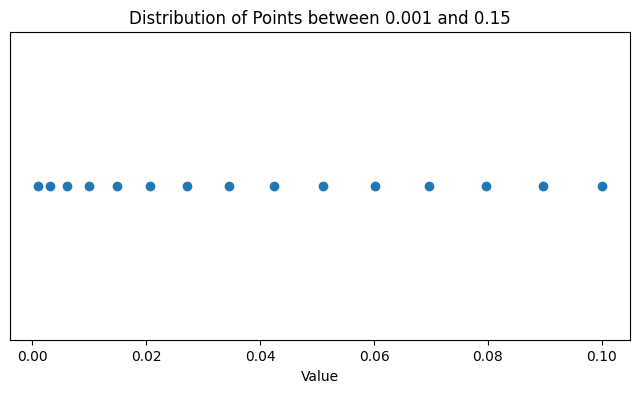

[0.0010128108731718146, 0.00302867869714807, 0.006028189562798407, 0.0099824565407872, 0.01485339787849419, 0.020594103748109886, 0.027149288013920816, 0.03445582066801904, 0.04244333580678849, 0.05103490929302295, 0.0601477995774181, 0.06969424454492273, 0.07958230671188203, 0.08971675863426365, 0.1]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Number of points you want to generate
num_sam_tr = 15  # You can change this number as needed

# Generate Chebyshev nodes in the interval [-1, 1]
n_diags = np.arange(1, num_sam_tr + 2)
x_k = np.cos(( 2*n_diags - 1) * np.pi / (4 * (num_sam_tr+1)))

# Map the nodes to the interval [0.001, 0.15] with higher density near 0.001
a = 0.001  # Start of the interval
b = 0.10   # End of the interval
s = (b*(x_k[1:]-x_k[0])/(x_k[-1]-x_k[0])).tolist()
# Optional: Plot the distribution of the points
plt.figure(figsize=(8, 4))
plt.plot(s, np.zeros_like(s), 'o')
plt.title('Distribution of Points between 0.001 and 0.15')
plt.xlabel('Value')
plt.yticks([])
plt.show()

# Print the generated points
print(s)


In [8]:
dates = pd.date_range(pd.Timestamp(year=2010,month=1,day=4), pd.Timestamp(year=2020,month=1,day=4), freq='B')
spare_dates = pd.DatetimeIndex(np.random.choice(dates, size=int(len(dates)*0.1), replace=False)).sort_values()
spare_dates

DatetimeIndex(['2010-01-11', '2010-01-12', '2010-01-15', '2010-01-20',
               '2010-02-04', '2010-02-25', '2010-04-19', '2010-04-27',
               '2010-05-07', '2010-06-22',
               ...
               '2019-08-27', '2019-09-16', '2019-09-19', '2019-09-27',
               '2019-10-15', '2019-10-24', '2019-11-01', '2019-12-03',
               '2019-12-18', '2020-01-02'],
              dtype='datetime64[ns]', length=261, freq=None)

In [9]:
assets: dict[str, AssetData] = AssetFileInOut("../src/stockGroups/bin").loadDictFromFile("group_snp500_over20years")
current_date: pd.Timestamp = pd.Timestamp.now(tz='UTC')
analysis_results = []
for ticker, asset in assets.items():
    priceData: pd.DataFrame = asset.shareprice.iloc[-21*6:-1]["Close"]
    priceData = priceData.resample('B').mean().dropna()
    priceDataVal=priceData.values
    analysis_results.append(CurveAnalysis.lineFit(priceDataVal/priceDataVal[0], ticker))

res = pd.DataFrame(analysis_results)
res['Rankslope'] = res['Slope'].rank(ascending=False)
res['Rankvar'] = res['Variance'].rank(ascending=True)
res['Score'] = res['Rankslope'] + res['Rankvar']
res.sort_values(by='Score', ascending=True, inplace=True)

In [10]:
res

,Ticker,Slope,Intercept,R_Value,P_Value,Std_Err,Variance,Rankslope,Rankvar,Score
37,BLK,0.003034,0.965029,0.979658,1.180007e-87,0.000056,0.000507,25.0,16.0,41.0
180,MSI,0.002882,1.004407,0.978581,2.726816e-86,0.000055,0.000483,34.0,11.0,45.0
184,NI,0.002611,0.995103,0.979174,4.939502e-87,0.000049,0.000385,47.0,1.0,48.0
33,BK,0.003085,0.969534,0.976290,1.316015e-83,0.000062,0.000614,23.0,31.0,54.0
20,AON,0.003012,1.002241,0.975662,6.449355e-83,0.000061,0.000602,26.0,29.0,55.0
...,...,...,...,...,...,...,...,...,...,...
134,HUM,-0.002989,1.126083,-0.812160,1.451059e-30,0.000194,0.006050,390.0,365.0,755.0
94,EW,-0.002450,1.003459,-0.728717,5.834908e-22,0.000208,0.006955,386.0,374.0,760.0
388,WBA,-0.003638,0.935470,-0.837947,3.817665e-34,0.000214,0.007370,392.0,378.0,770.0
311,MU,-0.002354,0.977910,-0.667231,1.959523e-17,0.000237,0.009061,385.0,385.0,770.0


{'Ticker': 'ZBRA', 'Slope': np.float64(18.615246954805105), 'Intercept': np.float64(7561.517231770834), 'R_Value': np.float64(0.8682961419977793), 'P_Value': np.float64(2.9209850923546793e-39), 'Std_Err': np.float64(0.9588937367350466), 'Variance': np.float64(148438.10020857948)}
LinregressResult(slope=np.float64(18.615246954805105), intercept=np.float64(7561.517231770834), rvalue=np.float64(0.8682961419977793), pvalue=np.float64(2.9209850923546793e-39), stderr=np.float64(0.9588937367350466), intercept_stderr=np.float64(68.78684222078785))
7561.517231770834


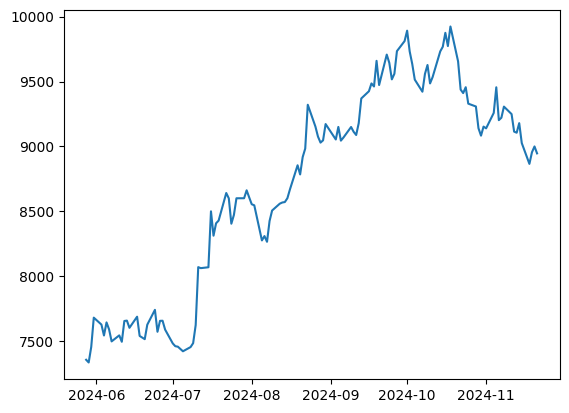

In [11]:
from scipy.stats import linregress
pdframe = assets["NVR"].shareprice.iloc[-21*6:-1]["Close"]
zeroval=pdframe.values[0]
plt.plot(pdframe)
a = CurveAnalysis.lineFit(pdframe.values, ticker)
print(a)
regression = linregress(np.arange(len(pdframe)), pdframe.values)
print(regression)
y_fit = regression.slope * np.arange(len(pdframe)) + regression.intercept
print(regression.intercept)

In [12]:
import polars as pl
from datetime import datetime, timedelta

# Generate sample data
start_date = datetime(2023, 1, 1)
data = {
    'timestamp': [start_date + timedelta(days=i) for i in range(10)],
    'price': [100 + i * 10 for i in range(10)]
}

priceData = pl.DataFrame(data)
print(priceData["price"].quantile(0.90))
print(type(priceData['price'].to_numpy()))

180.0
<class 'numpy.ndarray'>


In [13]:
print(pl.__version__)

1.14.0


In [14]:
# Resample to daily frequency and compute mean
resampled = priceData.group_by_dynamic(
    index_column='timestamp',
    every='1d',       # Window size of 1 day
    closed='left',    # Window is left-closed
    by=None           # No additional grouping
).agg([
    pl.col('price').mean().alias('price_mean')
]).drop_nulls()

print(resampled)

shape: (10, 2)
┌─────────────────────┬────────────┐
│ timestamp           ┆ price_mean │
│ ---                 ┆ ---        │
│ datetime[μs]        ┆ f64        │
╞═════════════════════╪════════════╡
│ 2023-01-01 00:00:00 ┆ 100.0      │
│ 2023-01-02 00:00:00 ┆ 110.0      │
│ 2023-01-03 00:00:00 ┆ 120.0      │
│ 2023-01-04 00:00:00 ┆ 130.0      │
│ 2023-01-05 00:00:00 ┆ 140.0      │
│ 2023-01-06 00:00:00 ┆ 150.0      │
│ 2023-01-07 00:00:00 ┆ 160.0      │
│ 2023-01-08 00:00:00 ┆ 170.0      │
│ 2023-01-09 00:00:00 ┆ 180.0      │
│ 2023-01-10 00:00:00 ┆ 190.0      │
└─────────────────────┴────────────┘


C:\Users\kimer\AppData\Local\Temp\ipykernel_2076\2642637582.py:2: DeprecationWarning: The argument `by` for `DataFrame.group_by_dynamic` is deprecated. It has been renamed to `group_by`.
  resampled = priceData.group_by_dynamic(


In [15]:
# Add a weekday column (0=Monday, 6=Sunday)
priceData = priceData.with_columns([
    pl.col('timestamp').dt.weekday().alias('weekday')
])

# Filter to include only business days (Monday=0 to Friday=4)
business_days = priceData.filter(pl.col('weekday').is_between(0, 4))

# Perform resampling on business days
resampled_business = business_days.group_by_dynamic(
    index_column='timestamp',
    every='1d',       # 1 day window
    closed='left'
).agg([
    pl.col('price').mean().alias('price_mean')
]).drop_nulls()

# Drop the auxiliary 'weekday' column if not needed
resampled_business = resampled_business.drop('weekday') if 'weekday' in resampled_business.columns else resampled_business

print(resampled_business)

shape: (6, 2)
┌─────────────────────┬────────────┐
│ timestamp           ┆ price_mean │
│ ---                 ┆ ---        │
│ datetime[μs]        ┆ f64        │
╞═════════════════════╪════════════╡
│ 2023-01-02 00:00:00 ┆ 110.0      │
│ 2023-01-03 00:00:00 ┆ 120.0      │
│ 2023-01-04 00:00:00 ┆ 130.0      │
│ 2023-01-05 00:00:00 ┆ 140.0      │
│ 2023-01-09 00:00:00 ┆ 180.0      │
│ 2023-01-10 00:00:00 ┆ 190.0      │
└─────────────────────┴────────────┘


In [16]:
# Sample data
data = {
    "ID": range(1, 21),  # IDs from 1 to 20
    "Slope": np.random.uniform(0, 100, 20),      # Random Slope values between 0 and 100
    "Variance": np.random.uniform(10, 50, 20)    # Random Variance values between 10 and 50
}

# Create a Polars DataFrame
results_df = pl.DataFrame(data)

In [18]:
sectors = {}
for ticker, asset in assets.items():
    sectors[asset.about["sectorKey"]] = asset.about["sectorKey"]

sectors.keys()

dict_keys(['industrials', 'healthcare', 'technology', 'utilities', 'financial-services', 'basic-materials', 'real-estate', 'consumer-defensive', 'energy', 'communication-services', 'consumer-cyclical'])

In [12]:
def getFourierConst(ft):
    """
    PRE: ft is a matrix of size (M x N). It is the evaluation of a function
        f: [-pi, pi)^M -> C^M at the points linspace(-pi, pi, N+1) (without end).
        N must be even. N should have low prime divisors (opt: N=2^m).
        f should be 2pi periodic.
    POST: CosConst and SinConst are matrices of size M x N/2.
    Desc:
        If f(t) = sum_{n=0}^{K} (a_n cos(nt) + b_n sin(nt)),
        then this function returns a_n and b_n as long as K <= N/2.
        Function can be vectorized along one dimension.
    NOTE:
     - ft can be complex. Then this program divides real part and imaginary part
       and combines them again.
    """
    M, N = ft.shape

    rFfft = np.fft.fft(np.real(ft), axis=1)
    iFfft = np.fft.fft(np.imag(ft), axis=1)
    cjrFfft = np.conj(rFfft)
    cjiFfft = np.conj(iFfft)

    signmat = (-1) ** np.arange(N)
    signmat = np.tile(signmat, (M, 1))

    ar = (rFfft + cjrFfft) * signmat / (N * 2)
    br = (rFfft - cjrFfft) * signmat * (1j) / (N * 2)

    ai = (iFfft + cjiFfft) * signmat / (N * 2)
    bi = (iFfft - cjiFfft) * signmat * (1j) / (N * 2)

    CosConst = (np.hstack([ar[:, :1], ar[:, 1:N//2] + np.fliplr(ar[:, N//2+1:])]) +
                1j * np.hstack([ai[:, :1], ai[:, 1:N//2] + np.fliplr(ai[:, N//2+1:])]))

    SinConst = (np.hstack([br[:, :1], br[:, 1:N//2] - np.fliplr(br[:, N//2+1:])]) +
                1j * np.hstack([bi[:, :1], bi[:, 1:N//2] - np.fliplr(bi[:, N//2+1:])]))

    return CosConst, SinConst

In [13]:
M = 1  # Number of functions (can be increased to test vectorization)
N = 64  # Number of sample points, must be even
# Known Fourier coefficients
a0 = 1.0
a1 = 0.5
a2 = 0.25
b1 = -0.3
b2 = 0.15
# Generate sample points
t = np.linspace(-np.pi, np.pi, N+1)[:-1] 

f_t = (a0 +
           a1 * np.cos(t) +
           a2 * np.cos(2 * t) +
           b1 * np.sin(t) +
           b2 * np.sin(2 * t))

f_t = f_t.reshape(M, N)

CosConst, SinConst = getFourierConst(f_t)

# Extract the computed coefficients
computed_a0 = CosConst[0, 0].real
computed_a1 = CosConst[0, 1].real
computed_a2 = CosConst[0, 2].real
computed_b1 = SinConst[0, 1].real
computed_b2 = SinConst[0, 2].real

# Print the known and computed coefficients
print("Known coefficients:")
print(f"a0 = {a0}, a1 = {a1}, a2 = {a2}, b1 = {b1}, b2 = {b2}")
print("\nComputed coefficients:")
print(f"a0 = {computed_a0}, a1 = {computed_a1}, a2 = {computed_a2}, b1 = {computed_b1}, b2 = {computed_b2}")

Known coefficients:
a0 = 1.0, a1 = 0.5, a2 = 0.25, b1 = -0.3, b2 = 0.15

Computed coefficients:
a0 = 1.0, a1 = 0.5, a2 = 0.25, b1 = -0.29999999999999993, b2 = 0.15000000000000002


In [20]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

# Load and preprocess data
(train_X, train_y), (test_X, test_y) = mnist.load_data()
train_X = train_X.reshape((60000, 28, 28, 1)).astype('float32') / 255
test_X = test_X.reshape((10000, 28, 28, 1)).astype('float32') / 255
train_y = to_categorical(train_y)
test_y = to_categorical(test_y)

print(type(train_X))
print(type(train_y))
print((train_X.shape))

# Build CNN model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])

# Compile and train
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
#model.fit(train_X, train_y, epochs=5, batch_size=64, validation_split=0.1)

# Evaluate
test_loss, test_acc = model.evaluate(test_X, test_y)
print(f'Test accuracy: {test_acc}')


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(60000, 28, 28, 1)
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0820 - loss: 2.3005
Test accuracy: 0.0812000036239624


Transformed training data shape: (60000, 1000)
Transformed testing data shape: (10000, 1000)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_14 (Dense)                │ (None, 512)            │       512,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 678,026 (2.59 MB)

 Trainable params: 678,026 (2.59 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
422/422 - 4s - 10ms/step - accuracy: 0.7034 - loss: 1.0054 - val_accuracy: 0.8833 - val_loss: 0.3614
Epoch 2/20
422/422 - 2s - 6ms/step - accuracy: 0.8463 - loss: 0.4647 - val_accuracy: 0.8982 - val_loss: 0.3204
Epoch 3/20
422/422 - 3s - 6ms/step - accuracy: 0.8697 - loss: 0.3921 - val_accuracy: 0.9213 - val_loss: 0.2458
Epoch 4/20
422/422 - 3s - 6ms/step - accuracy: 0.8814 - loss: 0.3565 - val_accuracy: 0.9227 - val_loss: 0.2392
Epoch 5/20
422/422 - 2s - 6ms/step - accuracy: 0.8949 - loss: 0.3200 - val_accuracy: 0.9338 - val_loss: 0.2169
Epoch 6/20
422/422 - 2s - 6ms/step - accuracy: 0.9030 - loss: 0.2946 - val_accuracy: 0.9300 - val_loss: 0.2261
Epoch 7/20
422/422 - 3s - 6ms/step - accuracy: 0.9059 - loss: 0.2805 - val_accuracy: 0.9353 - val_loss: 0.2110
Epoch 8/20
422/422 - 2s - 6ms/step - accuracy: 0.9121 - loss: 0.2673 - val_accuracy: 0.9312 - val_loss: 0.2275
Epoch 9/20
422/422 - 2s - 6ms/step - accuracy: 0.9162 - loss: 0.2515 - val_accuracy: 0.9398 - val_loss: 0.2045


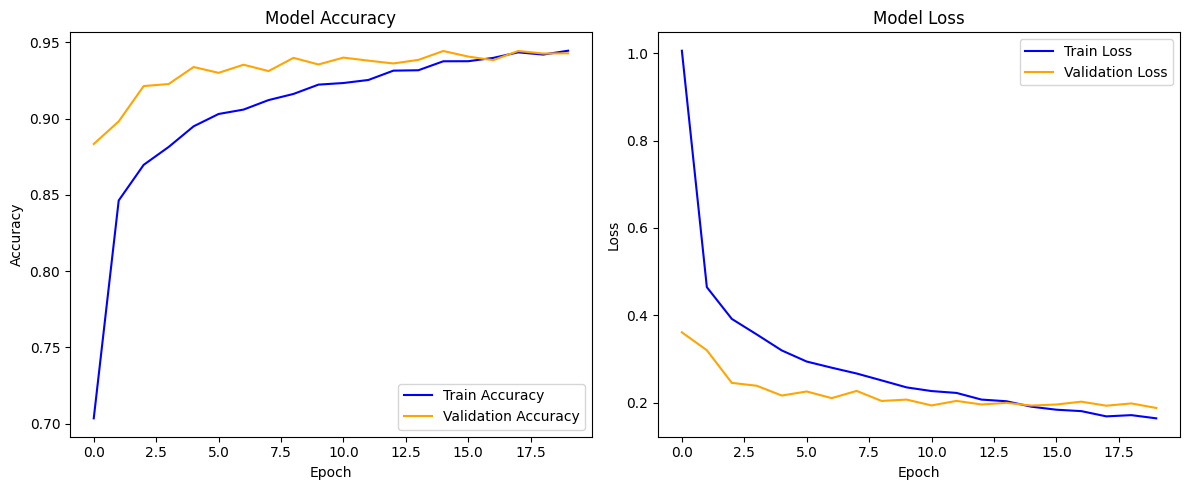

In [22]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

def getFourierConst(image, desired_length=1000):
    """
    Transforms a 2D image into a 1D Fourier-based feature vector of specified length.
    
    Parameters:
    - image: 2D numpy array representing the grayscale image.
    - desired_length: The length of the output feature vector (default is 1000).
    
    Returns:
    - features: 1D numpy array of length `desired_length`.
    """
    # Compute 2D FFT
    fft = np.fft.fft2(image)
    
    # Shift the zero-frequency component to the center
    fft_shift = np.fft.fftshift(fft)
    
    # Flatten the FFT result
    fft_flat = fft_shift.flatten()
    
    # Compute magnitude and phase
    magnitude = np.abs(fft_flat)
    phase = np.angle(fft_flat)
    
    # Combine magnitude and phase
    features = np.concatenate([magnitude, phase])
    
    # Adjust the feature vector to the desired length
    if len(features) > desired_length:
        features = features[:desired_length]
    elif len(features) < desired_length:
        features = np.pad(features, (0, desired_length - len(features)), 'constant')
    
    return features

# Load MNIST data
(train_X, train_y), (test_X, test_y) = mnist.load_data()

# Normalize the images to [0, 1]
train_X = train_X.astype('float32') / 255.0
test_X = test_X.astype('float32') / 255.0

# Convert labels to one-hot encoding
train_y = to_categorical(train_y)
test_y = to_categorical(test_y)

# Apply getFourierConst to each image in the training set
train_features = np.array([getFourierConst(image) for image in train_X])

# Apply getFourierConst to each image in the testing set
test_features = np.array([getFourierConst(image) for image in test_X])

print(f"Transformed training data shape: {train_features.shape}")
print(f"Transformed testing data shape: {test_features.shape}")

# Define the MLP model
model = models.Sequential([
    layers.Dense(512, activation='relu', input_shape=(1000,)),
    layers.Dropout(0.2),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(128, activation='relu'),
    layers.Dense(10, activation='softmax')
])

# Display the model architecture
model.summary()

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(train_features, train_y,
                    epochs=20,
                    batch_size=128,
                    validation_split=0.1,
                    verbose=2)

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_features, test_y, verbose=0)
print(f'\nTest accuracy: {test_acc:.4f}')

# Plot training & validation accuracy and loss
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()


In [23]:
train_features.shape

(60000, 1000)